<a href="https://colab.research.google.com/github/H-a-m-za/Sudoko/blob/main/Computer_Vision_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PHASE I

Importing libraries

In [ ]:
%matplotlib inline
import cv2
import urllib
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

Inputing and Displaying dataset

In [ ]:
testImagesLinks = ['https://i.cbc.ca/1.4580539.1521235681!/fileImage/httpImage/image.png_gen/derivatives/16x9_780/sudoku-guy-robin-jarman.png',
                   'https://live.staticflickr.com/8027/6978422072_33ac92fe1a_b.jpg',
                   'https://sources.roboflow.com/dcbM99GUgvVCEMo4F2rq8vaVApB2/DSJGI2e7g77XqctWIGQG/original.jpg']

link = testImagesLinks[0]
req = urllib.request.urlopen(link)
arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
img = cv2.imdecode(arr, cv2.IMREAD_COLOR) # 'Load it as it is'
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

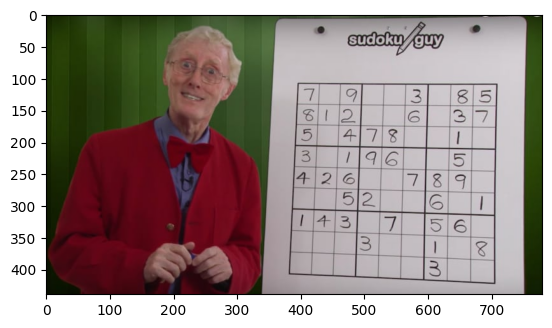

In [ ]:
plt.imshow(img_rgb)

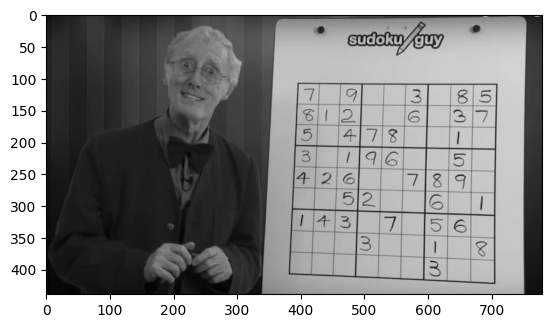

In [ ]:
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
plt.imshow(img_gray, cmap="gray");


Let's try normal thresholding

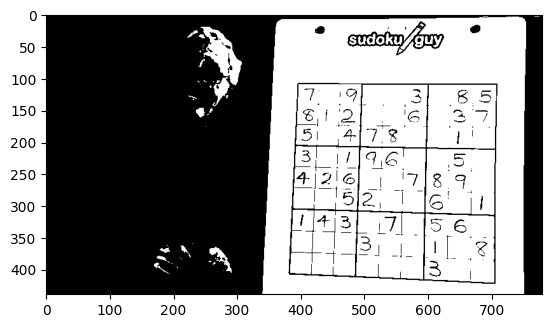

In [ ]:
img_global_threshold = cv2.threshold(img_gray,
                                     127,
                                     255,
                                     cv2.THRESH_BINARY)[1] #Apparently threshold function returns three things, The second item is the image
plt.imshow(img_global_threshold, cmap = "gray")

Adaptive Thresholding has proven to be better

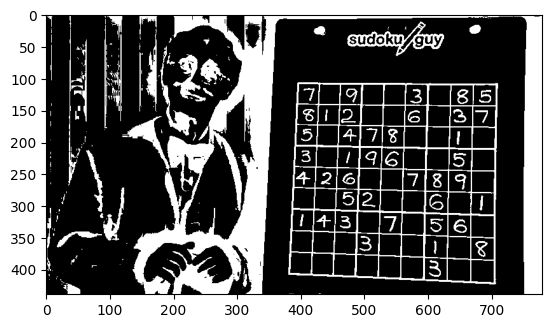

In [ ]:
img_gray_threshed = cv2.adaptiveThreshold(src=img_gray,
    maxValue=255,
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    thresholdType=cv2.THRESH_BINARY_INV,
    blockSize=111,
    C=5
)
plt.imshow(img_gray_threshed, cmap="gray");

Max Filter Implementation

In [ ]:
def maxFilter(image,kernel):
  padded = np.pad(image, pad_width=2, mode="constant",constant_values = (0,0))
  result = np.zeros((padded.shape[0],padded.shape[1]))
  for i in range(0, padded.shape[0] - kernel + 1):
      for j in range(0, padded.shape[1] - kernel + 1):
          window = padded[i:i+kernel, j:j+kernel]
          result[i, j] = np.max(window)
  return result[2:padded.shape[0]-2, 2:padded.shape[1]-2]

We tried max filtered but it failed miserably

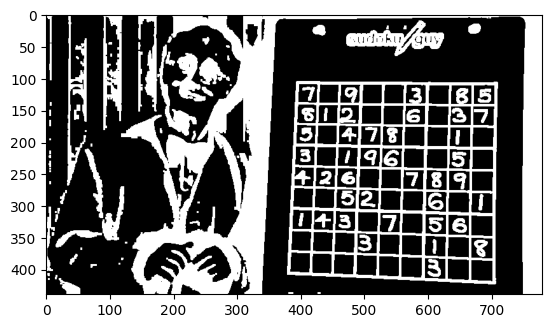

In [ ]:
max_filtered = maxFilter(img_gray_threshed,3)
plt.imshow(max_filtered,cmap = "gray")

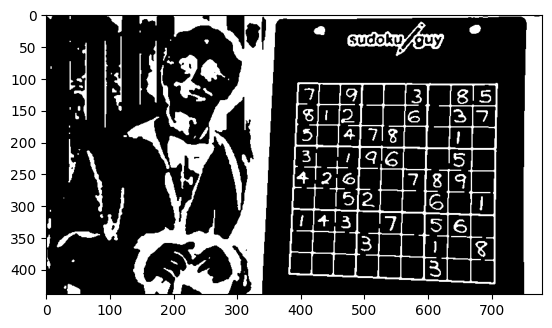

In [ ]:
median_filtered = img_gray_threshed
for i in range(3):
  median_filtered = cv2.medianBlur(median_filtered,3)
plt.imshow(median_filtered,cmap = "gray")

Let's Try Hough Transform

[[[199   1 779   1]]

 [[310   3 779   3]]

 [[310   2 779   2]]

 [[310   4 711   4]]

 [[195   0 779   0]]

 [[393 109 710 109]]

 [[310   5 699   5]]

 [[382 338 706 350]]

 [[381 370 706 387]]

 [[379 406 706 423]]

 [[393 108 710 108]]

 [[753  39 766 438]]

 [[764   4 772 438]]

 [[328 438 358   6]]

 [[389 204 708 209]]

 [[455 238 707 246]]

 [[308 429 338   6]]

 [[390 172 708 178]]

 [[777 438 777   4]]

 [[462 208 708 213]]

 [[445 372 706 385]]

 [[426 110 710 110]]

 [[767 438 775   4]]

 [[384 302 706 313]]

 [[390 171 708 177]]

 [[317 438 355   6]]

 [[776 438 776   4]]

 [[473 207 707 211]]

 [[330 438 360   6]]

 [[319 438 357   6]]

 [[314 438 352   6]]

 [[757 342 774   4]]

 [[331 438 361   6]]

 [[196 300 359   6]]

 [[379 404 707 421]]

 [[393 107 710 107]]

 [[385 270 707 281]]

 [[778 438 778   4]]

 [[750 392 756   4]]

 [[384 303 706 315]]

 [[310 427 339   6]]

 [[779 438 779   4]]

 [[751 438 759   4]]

 [[382 336 706 348]]

 [[382 340 706 351]]

 [[310   6

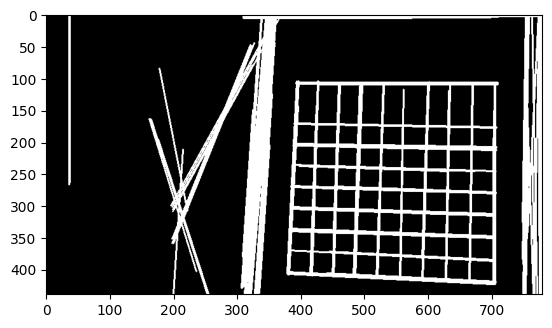

In [ ]:
# Detect lines that are not smaller in length than:

image = np.asarray(max_filtered, dtype=np.uint8)

minLineLength = min(image.shape[0],image.shape[1])/2

lines = cv2.HoughLinesP(
    image=image,
    rho=1,
    theta=np.pi/180,
    threshold=150,
    minLineLength=minLineLength,
    maxLineGap=17
)

tmp_img = np.zeros_like(image, dtype = np.uint8)
for x1, y1, x2, y2 in lines[:,0]: cv2.line(tmp_img,(x1,y1),(x2,y2),(255,0,0),2)
plt.imshow(tmp_img, cmap='gray');
print(lines)

Let's Try Canny

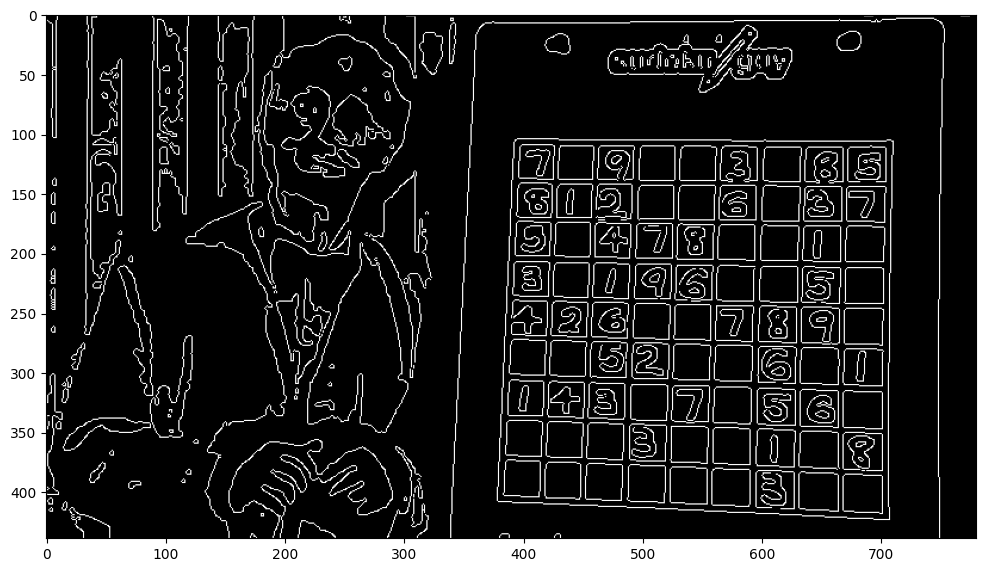

In [ ]:
img_blurred = np.asarray(cv2.GaussianBlur(src=max_filtered, ksize=(3, 3), sigmaX=0),dtype = 'uint8')
img_canny = cv2.Canny(image=img_blurred,
                      apertureSize=3,
                      threshold1=120,
                      threshold2=200,
                      L2gradient=True)
plt.figure(figsize=(12, 8))
plt.imshow(img_canny, cmap="gray");

Let's try

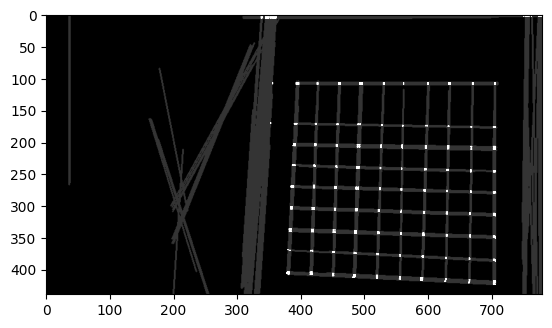

In [ ]:
tmp_img2 = np.zeros_like(img_gray_threshed, dtype = np.uint16)

def angle_between_lines(line1, line2):
    l1x1, l1y1, l1x2, l1y2 = line1
    l2x1, l2y1, l2x2, l2y2 = line2
    a1 = np.rad2deg(np.arctan2(l1y2 - l1y1, l1x2 - l1x1))
    a2 = np.rad2deg(np.arctan2(l2y2 - l2y1, l2x2 - l2x1))
    return np.abs(a1 - a2)

def intersection_point(line1, line2):
    # https://en.wikipedia.org/wiki/Line%E2%80%93line_intersection
    l1x1, l1y1, l1x2, l1y2 = line1
    l2x1, l2y1, l2x2, l2y2 = line2
    nx = (l1x1*l1y2-l1y1*l1x2)*(l2x1-l2x2)-(l2x1*l2y2-l2y1*l2x2)*(l1x1-l1x2)
    ny = (l1x1*l1y2-l1y1*l1x2)*(l2y1-l2y2)-(l2x1*l2y2-l2y1*l2x2)*(l1y1-l1y2)
    d = (l1x1-l1x2)*(l2y1-l2y2)-(l1y1-l1y2)*(l2x1-l2x2)
    px = int(nx / d)
    py = int(ny / d)
    return (px, py)

def point_on_line(point, line):
    def distance(pfrom, pto): return np.sqrt((pfrom[0] - pto[0])**2 + (pfrom[1] - pto[1])**2)
    diff = distance(point, line[0:2]) + distance(point, line[2:4]) - distance(line[0:2], line[2:4])
    return np.abs(diff) < 75

intersections = []
num_of_lines = len(lines[:,0])
for i in range(num_of_lines):
    for j in range(i+1, num_of_lines):
        line1 = lines[i,0]
        line2 = lines[j,0]
        if (line1 is line2): continue
        a = angle_between_lines(line1, line2)
        if (a < 80 or a > 100): continue
        p = intersection_point(line1, line2)
        if point_on_line(p, line1) and point_on_line(p, line2):
            tmp_img2[p[::-1]] = 5000
            intersections.append(p[::-1])

plt.imshow(tmp_img2 + tmp_img, cmap="gray", vmin=0, vmax=1255);

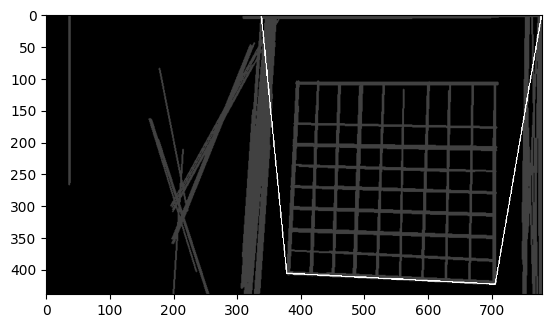

In [ ]:
p1 = sorted(intersections, key = lambda p: p[0] + p[1])[0] # topleft
p2 = sorted(intersections, key = lambda p: p[0] - p[1])[0] # topright
p3 = sorted(intersections, key = lambda p: p[0] + p[1])[-1] # bottright
p4 = sorted(intersections, key = lambda p: p[1] - p[0])[0] # bottleft
coords = np.int32([[p1[::-1], p2[::-1], p3[::-1], p4[::-1]]])
tmp_img3 = np.zeros_like(img_gray_threshed, dtype = np.int32)
tmp_img3 = cv2.polylines(tmp_img3, coords, isClosed=True, color=(2550,0,0))
plt.imshow(tmp_img3 + tmp_img, cmap="gray", vmax=1000);

In [ ]:
y, x = img_gray_threshed.shape
src_coords = np.float32([[0,0], [x,0], [x,y], [0,y]])
dst_coords = np.float32([[p1[::-1], p2[::-1], p3[::-1], p4[::-1]]])
img_gray_threshed_warped = cv2.warpPerspective(
    src=img_gray_threshed,
    M=cv2.getPerspectiveTransform(dst_coords, src_coords),
    dsize=img_gray_threshed.shape[::-1]
)
plt.imshow(img_gray_threshed_warped, cmap="gray");